In [2]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt

In [11]:
root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-61_date-20250618/behav/2025-06-18T15-58-52')

In [12]:
metadata_reader = utils.SessionData()
session_settings = utils.load_json(metadata_reader, root/"SessionSettings")
print(session_settings.iloc[0]['metadata'].sequences)

/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-61_date-20250618/behav/2025-06-18T15-58-52/SessionSettings/SessionSettings_*.jsonl
[[{'rewardConditions': [{'definition': [[{'command': 'OdorC', 'rewarded': False, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}], [{'command': 'OdorA', 'rewarded': True, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}]], 'position': 0}], 'interCommand': 'Purge', 'interCommandTime': 0.2, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardAttempts': 0, 'responseTime': 99999.0, 'interTrialInterval': 0.0, 'name': 'DoublesA_Stage1', 'defaultCommand': 'Default', 'maximumTime': 10.0, 'resetOnReward': True}, {'rewardConditions': [{'definition': [[{'command': 'OdorD', 'rewarded': False, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}], [{'command': 'OdorA', 'rewarded': True, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}]], 'position': 0}],

In [15]:
# Load relevant data streams
behavior_reader = harp.create_reader('device_schemas/behavior.yml', epoch=harp.REFERENCE_EPOCH)
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)
video_reader = utils.Video()
video_data = utils.load_video(video_reader, root/"VideoData")

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
olfactometer_end_1 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer1")
analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# 'other' events
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior")
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior")

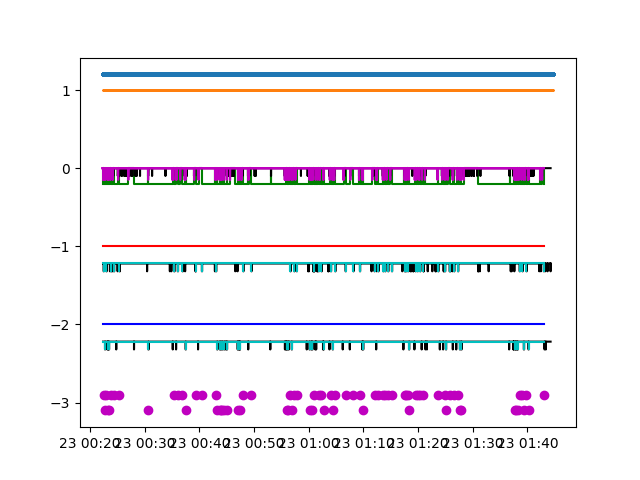

In [ ]:
## Plot events of interest for debugging

# find initiation onsets, reward pokes
initiating_events = digital_input_data['DIPort0'][digital_input_data['DIPort0'] == True]
odour_led = utils.concat_digi_events(output_clear['DOPort0'], output_set['DOPort0']) # high is set by the true value of output_set while the low is set by the true value of output_clear
r1_led = utils.concat_digi_events(output_clear['DOPort1'], output_set['DOPort1'])
r2_led = utils.concat_digi_events(output_clear['DOPort2'], output_set['DOPort2'])

plt.figure()

# plot odour pokes events
plt.step(odour_led.index, odour_led * -0.2, where='post', c='g') # odour port LED
plt.step(digital_input_data.index, digital_input_data['DIPort0'] * -0.1, where='post', c='k') # odour port pokes

# plot odour valve events
plt.step(olfactometer_valves_0.index, olfactometer_valves_0 * -0.15, where='post', c='m') # olfactometer 1 valve events

# plot lick port A events
plt.step(r1_led.index, r1_led * 0.6 - 1, where='post', c='r') # lick port A LED
plt.step(digital_input_data.index, digital_input_data['DIPort1'] * -0.1 - 1.22, where='post', c='k') # lick port A pokes
plt.step(output_set.index, output_set["SupplyPort1"] * -0.1 - 1.22, where='post', c='c') # rewards for lick port A

# plot lick port B events
plt.step(r2_led.index, r2_led * 0.6 - 2, where='post', c='b') # lick port B LED
plt.step(digital_input_data.index, digital_input_data['DIPort2'] * -0.1 - 2.22, where='post', c='k') # lick port B pokes 
plt.step(output_set.index, output_set["SupplyPort2"] * -0.1 - 2.22, where='post', c='c') # rewards for lick port B

plt.scatter(video_data.index, np.ones((len(video_data.index), 1)) + 0.2, s=2.5)
plt.scatter(heartbeat.index, np.ones((len(heartbeat.index), 1)), s=0.1)
#plt.plot(analog_data.index, analog_data['AnalogInput0'] * 0.1)

# other events that may be useful to look at
plt.scatter(pulse_supply_1.index, np.ones((len(pulse_supply_1.index), 1)) - 3.9, c='m')
plt.scatter(pulse_supply_2.index, np.ones((len(pulse_supply_2.index), 1)) - 4.1, c='m')


In [204]:
# Load olfactometer events
try:
    olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
except ValueError:
    olfactometer_valves_0 = pd.DataFrame(columns=['Time', 'Valve0', 'Valve1', 'Valve2', 'Valve3'])

try:
    olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
    olfactometer_valves_1 = olfactometer_valves_1.rename(columns={
        'Valve0': 'Valve4',
        'Valve1': 'Valve5',
        'Valve2': 'Valve6',
        'Valve3': 'Valve7',
    })
except ValueError:
    olfactometer_valves_1 = pd.DataFrame(columns=['Time', 'Valve0', 'Valve1', 'Valve2', 'Valve3'])
 
    

In [205]:
# Load heartbeat 
try:
    heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")
except Exception as e:
    print(f"Error loading timestamp data: {e}")
    heartbeat = pd.DataFrame(columns=['Time', 'TimestampSeconds'])

# Reset indices for non-empty dataframes
if not heartbeat.empty:
    heartbeat.reset_index(inplace=True)


In [206]:
# Get EndInitiation events
real_time_offset = pd.Timedelta(0)
if not heartbeat.empty and 'Time' in heartbeat.columns and len(heartbeat) > 0:
    try:
        real_time_str = root.name
        match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
        if match:
            real_time_str = match.group(0)
        else:
            # Try parent directory
            real_time_str = root.parent.name
            match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
            if match:
                real_time_str = match.group(0)
        
        if re.match(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str):
            real_time_ref_utc = datetime.datetime.strptime(real_time_str, '%Y-%m-%dT%H-%M-%S')
            real_time_ref_utc = real_time_ref_utc.replace(tzinfo=datetime.timezone.utc)
            uk_tz = zoneinfo.ZoneInfo("Europe/London")
            real_time_ref = real_time_ref_utc.astimezone(uk_tz)
            
            start_time_hardware = heartbeat['Time'].iloc[0]
            start_time_dt = start_time_hardware.to_pydatetime()
            if start_time_dt.tzinfo is None:
                start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
            real_time_offset = real_time_ref - start_time_dt
    except Exception as e:
        print(f"Error calculating real-time offset: {e}")

# # Apply time offset to non-empty DataFrames
# if not olfactometer_valves_0_abs.empty and 'Time' in olfactometer_valves_0_abs.columns:
#     olfactometer_valves_0_abs['Time'] = olfactometer_valves_0_abs['Time'] + real_time_offset

# Map heartbeat times if we have data
timestamp_to_time = pd.Series()
if not heartbeat.empty and 'Time' in heartbeat.columns and 'TimestampSeconds' in heartbeat.columns:
    heartbeat['Time'] = pd.to_datetime(heartbeat['Time'], errors='coerce')
    timestamp_to_time = pd.Series(data=heartbeat['Time'].values, index=heartbeat['TimestampSeconds'])

def interpolate_time(seconds):
    """Interpolate timestamps from seconds, with safety checks"""
    if timestamp_to_time.empty:
        return pd.NaT
    int_seconds = int(seconds)
    fractional_seconds = seconds % 1
    if int_seconds in timestamp_to_time.index:
        base_time = timestamp_to_time.loc[int_seconds]
        return base_time + pd.to_timedelta(fractional_seconds, unit='s')
    return pd.NaT

end_initiation_frames = []
experiment_events_dir = root / "ExperimentEvents"

if experiment_events_dir.exists():
    csv_files = list(experiment_events_dir.glob("*.csv"))
    print(f"Found {len(csv_files)} experiment event files")
    
    for csv_file in csv_files:
        try:
            ev_df = pd.read_csv(csv_file)
            print(f"Processing event file: {csv_file.name} with {len(ev_df)} rows")
            
            # Use Seconds field if available, otherwise use Time field
            if "Seconds" in ev_df.columns and not timestamp_to_time.empty:
                ev_df = ev_df.sort_values("Seconds").reset_index(drop=True)
                ev_df["Time"] = ev_df["Seconds"].apply(interpolate_time)
                print(f"Using Seconds column for interpolation")
            else:
                ev_df["Time"] = pd.to_datetime(ev_df["Time"], errors="coerce")
                print(f"Using Time column directly")
            
            if "Time" in ev_df.columns:
                # ev_df["Time"] = ev_df["Time"] + real_time_offset
                
                if "Value" in ev_df.columns:
                    print(f"Found Value column with values: {ev_df['Value'].unique()}")
                    eii_df = ev_df[ev_df["Value"] == "EndInitiation"].copy()
                    if not eii_df.empty:
                        print(f"Found {len(eii_df)} EndInitiation events")
                        eii_df["EndInitiation"] = True
                        end_initiation_frames.append(eii_df[["Time", "EndInitiation"]])
        except Exception as e:
            print(f"Error processing event file {csv_file.name}: {e}")
else:
    print("No ExperimentEvents directory found")

    
if len(end_initiation_frames) > 0:
    combined_end_initiation_df = pd.concat(end_initiation_frames, ignore_index=True)
    combined_end_initiation_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_end_initiation_df)} EndInitiation events")
else:
    combined_end_initiation_df = pd.DataFrame(columns=["Time", "EndInitiation"])
    print("No EndInitiation events found - cannot identify trial endings")



Found 2 experiment event files
Processing event file: ExperimentEvents_1904-03-23T01-00-00.csv with 402 rows
Using Seconds column for interpolation
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']
Found 67 EndInitiation events
Processing event file: ExperimentEvents_1904-03-23T00-00-00.csv with 297 rows
Using Seconds column for interpolation
Found Value column with values: ['ChooseRandomSequence' 'SampleRewardCondition' 'InitiationSequence'
 'EndInitiation' 'AwaitReward' 'Reset']
Found 49 EndInitiation events
Combined 116 EndInitiation events


In [ ]:
# Convert all dataframes to the right format 
digital_input_data_abs = digital_input_data[['DIPort0', 'DIPort1']].copy() if not digital_input_data.empty else pd.DataFrame()
olfactometer_valves_0_abs = olfactometer_valves_0.copy() if not olfactometer_valves_0.empty else pd.DataFrame()
olfactometer_valves_1_abs = olfactometer_valves_1.copy() if not olfactometer_valves_1.empty else pd.DataFrame()
output_set_abs = output_set[['SupplyPort1', 'SupplyPort2']].copy() if not output_set.empty else pd.DataFrame()

# Derive real-time offset
real_time_str = root.as_posix().split('/')[-1]
real_time_ref_utc = datetime.datetime.strptime(
    real_time_str, '%Y-%m-%dT%H-%M-%S'
).replace(tzinfo=datetime.timezone.utc)
uk_tz = zoneinfo.ZoneInfo("Europe/London")
real_time_ref = real_time_ref_utc.astimezone(uk_tz)

start_time_hardware = heartbeat['Time'].iloc[0]
start_time_dt = start_time_hardware.to_pydatetime()
if start_time_dt.tzinfo is None:
    start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
real_time_offset = real_time_ref - start_time_dt

# Shift data
# digital_input_data_abs = digital_input_data.copy()
# pulse_supply_1_abs = pulse_supply_1.copy()
# pulse_supply_2_abs = pulse_supply_2.copy()
    

# Make sure all have a 'Time' column and no index conflicts
for df_abs in [digital_input_data_abs, olfactometer_valves_0_abs, olfactometer_valves_1_abs, output_set_abs, combined_end_initiation_df]:
    if not df_abs.empty:
        if df_abs.index.name is not None or df_abs.index.names != [None]:
            df_abs.reset_index(inplace=True)
    else:
        print('Empty dataframe encountered.')

# Combine all events into one dataframe 
# event_frames = []
# event_frames.append(combined_end_initiation_df)
# event_frames.append(digital_input_data_abs)
# event_frames.append(olfactometer_valves_0_abs)
# event_frames.append(olfactometer_valves_1_abs)
# event_frames.append(output_set_abs)

# if event_frames:
#     all_events_df = pd.concat(event_frames, ignore_index=False)

# Merge all dataframes on 'Time'
from functools import reduce

dfs_to_merge = [combined_end_initiation_df, digital_input_data_abs, olfactometer_valves_0_abs, olfactometer_valves_1_abs, output_set_abs]
# Filter out empty dataframes
dfs_to_merge = [df for df in dfs_to_merge if not df.empty]

for df_abs in dfs_to_merge:
    df_abs['Time'] = df_abs['Time'] + real_time_offset

# Merge all on 'Time' (outer join keeps all timestamps, merging by shared times)
all_events_df = reduce(lambda left, right: pd.merge(left, right, on='Time', how='outer'), dfs_to_merge)

# Final formatting
all_events_df.fillna(False, inplace=True).infer_objects(copy=False)
all_events_df.sort_values('Time', inplace=True)
all_events_df.rename(columns={'Time': 'timestamp'}, inplace=True)
all_events_df.reset_index(drop=True, inplace=True)

print(all_events_df)

                         timestamp  EndInitiation  DIPort0  DIPort1  Valve0  \
0    2025-06-18 16:58:51.928480000          False    False    False   False   
1    2025-06-18 16:58:51.929504000          False    False    False   False   
2    2025-06-18 16:58:51.970496000          False    False    False   False   
3    2025-06-18 16:58:57.440448000          False     True    False   False   
4    2025-06-18 16:58:57.521503999          False    False    False   False   
...                            ...            ...      ...      ...     ...   
2912 2025-06-18 18:19:57.426752000          False    False    False   False   
2913 2025-06-18 18:20:15.998880000          False    False     True   False   
2914 2025-06-18 18:20:16.100992000          False    False    False   False   
2915 2025-06-18 18:20:49.349600000          False    False     True   False   
2916 2025-06-18 18:20:49.578176000          False    False    False   False   

      Valve1  Valve2  Valve3  Valve4  Valve5  Valve

/var/folders/hb/19x78jb503d4_x8gkyw7xdz00000gn/T/ipykernel_95762/1110109090.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_events_df.fillna(False, inplace=True)


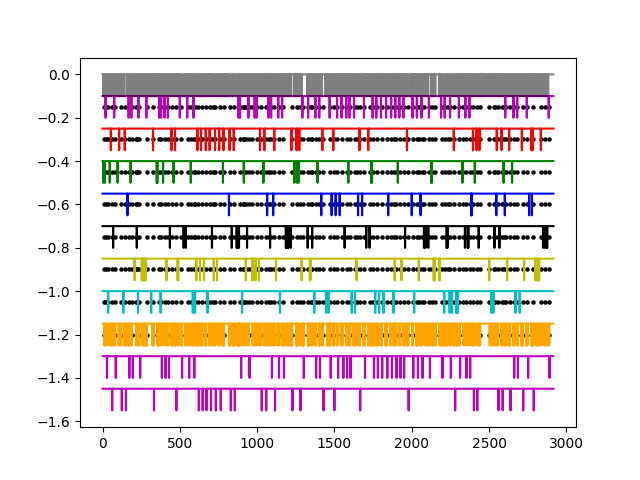

In [ ]:
# Plot all events for Freerun 
plt.figure()

# plot odour valve and trial end events
plt.step(all_events_df['Valve0'].index, all_events_df['Valve0'] * -0.1 - 0.1, where='post', c='m') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.15, s=5, c='k')

plt.step(all_events_df['Valve1'].index, all_events_df['Valve1'] * -0.1 - 0.25, where='post', c='r') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.3, s=5, c='k')

plt.step(all_events_df['Valve2'].index, all_events_df['Valve2'] * -0.1 - 0.4, where='post', c='g') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.45, s=5, c='k')

plt.step(all_events_df['Valve3'].index, all_events_df['Valve3'] * -0.1 - 0.55, where='post', c='b') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.6, s=5, c='k')

plt.step(all_events_df['Valve4'].index, all_events_df['Valve4'] * -0.1 - 0.7, where='post', c='k') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.75, s=5, c='k')

plt.step(all_events_df['Valve5'].index, all_events_df['Valve5'] * -0.1 - 0.85, where='post', c='y') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 1.9, s=5, c='k')

plt.step(all_events_df['Valve6'].index, all_events_df['Valve6'] * -0.1 - 1, where='post', c='c') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 2.05, s=5, c='k')

plt.step(all_events_df['Valve7'].index, all_events_df['Valve7'] * -0.1 - 1.15, where='post', c='orange') # olfactometer 1 valve events
plt.scatter(all_events_df[all_events_df['EndInitiation']==True].index, np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) - 2.2, s=5, c='k')

# plot odour pokes events
plt.step(all_events_df.index, all_events_df['DIPort0'] * -0.1, where='post', c='k', alpha=0.5) # odour port pokes

# plot reward port A pokes
plt.step(all_events_df.index, all_events_df["SupplyPort1"] * -0.1 - 1.3, where='post', c='m') # lick port A pokes

# plot reward port B events
plt.step(all_events_df.index, all_events_df["SupplyPort2"] * -0.1 - 1.45, where='post', c='m') # lick port B pokes 


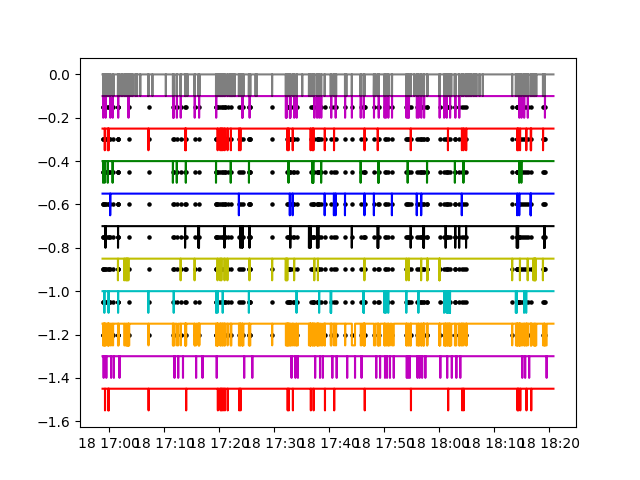

In [ ]:
# Plot all events on time axis for Freerun
# NOTE: The duration of the events is not accurate. To accurate plot that, each dataframe events should be plotted separately, 
# because the plotting of each event lasts until the next timestamp instead of until the value of that event turns to False, 
# which should be accurately logged in the corresponding original dataframe. 

plt.figure()

time = all_events_df['timestamp']

plt.step(time, all_events_df['Valve0'].astype(int) * -0.1 - 0.1, where='post', c='m')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.15, s=5, c='k')

plt.step(time, all_events_df['Valve1'].astype(int) * -0.1 - 0.25, where='post', c='r')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.3, s=5, c='k')

plt.step(time, all_events_df['Valve2'].astype(int) * -0.1 - 0.4, where='post', c='g')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.45, s=5, c='k')

plt.step(time, all_events_df['Valve3'].astype(int) * -0.1 - 0.55, where='post', c='b')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.6, s=5, c='k')

plt.step(time, all_events_df['Valve4'].astype(int) * -0.1 - 0.7, where='post', c='k')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.75, s=5, c='k')

plt.step(time, all_events_df['Valve5'].astype(int) * -0.1 - 0.85, where='post', c='y')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -1.9, s=5, c='k')

plt.step(time, all_events_df['Valve6'].astype(int) * -0.1 - 1, where='post', c='c')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -2.05, s=5, c='k')

plt.step(time, all_events_df['Valve7'].astype(int) * -0.1 - 1.15, where='post', c='orange')
plt.scatter(time[all_events_df['EndInitiation']==True], np.ones((len(all_events_df[all_events_df['EndInitiation']==True]), 1)) -2.2, s=5, c='k')

plt.step(time, all_events_df['DIPort0'].astype(int) * -0.1, where='post', c='k', alpha=0.5)

plt.step(time, all_events_df["SupplyPort1"].astype(int) * -0.1 - 1.3, where='post', c='m') # lick port A pokes

# plot lick port B events
plt.step(time, all_events_df["SupplyPort2"].astype(int) * -0.1 - 1.45, where='post', c='r') # lick port B pokes 
